# Разрешение анафоры. Тест с несколькими моделями-трансформерами

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
pip install transformers seqeval

In [0]:
import os
import json
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoConfig, AutoTokenizer
from transformers import AutoModelForTokenClassification, AdamW
from transformers import XLNetTokenizer, BertTokenizer
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, classification_report

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12, 6)

Using TensorFlow backend.


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla P100-PCIE-16GB


# Загрузка датасета

[CLUEWSC2020: WSC Winograd, Китайская версия](https://storage.googleapis.com/cluebenchmark/tasks/cluewsc2020_public.zip).

In [0]:
#!wget https://storage.googleapis.com/cluebenchmark/tasks/cluewsc2020_public.zip

In [0]:
#!unzip /content/cluewsc2020_public.zip

# Функции

In [0]:
tag2idx = {
    'PAD': 0,
    'O': 1,
    'SPAN_1': 2,
    'SPAN_2': 3
}
tag_values = list(tag2idx.keys())

In [0]:
# Создаём датасет
def json2io(filename, tokenizer):
    sentences = []
    labels = []
    with open(filename) as f:
        for jline in f:
            data = json.loads(jline)
            if 'label' in data.keys() and data['label'] == 'true':
                span1_tokens = tokenizer.tokenize(data['target']['span1_text'])
                span2_tokens = tokenizer.tokenize(data['target']['span2_text'])
                full_text_tokens = tokenizer.tokenize(data['text'])

                if len(full_text_tokens) != len(data['text']):
                    pass
                else:
                    ft_labels = list('O'*len(full_text_tokens))
                    # S1
                    pos_start = data['target']['span1_index']
                    for i in range(len(span1_tokens)):
                        position = pos_start + i
                        ft_labels[position] = 'SPAN_1'
                    
                    # S2
                    pos_start = data['target']['span2_index']
                    for i in range(len(span2_tokens)):
                        position = pos_start + i
                        ft_labels[position] = 'SPAN_2'
                    
                    # append data
                    assert len(full_text_tokens) == len(ft_labels)
                    sentences.append(full_text_tokens)
                    labels.append(ft_labels)
            else:
                span1_tokens = tokenizer.tokenize(data['target']['span1_text'])
                span2_tokens = tokenizer.tokenize(data['target']['span2_text'])
                full_text_tokens = tokenizer.tokenize(data['text'])

                if len(full_text_tokens) != len(data['text']):
                    pass
                else:
                    ft_labels = list('O'*len(full_text_tokens))
                    # S1
                    pos_start = data['target']['span1_index']
                    for i in range(len(span1_tokens)):
                        position = pos_start + i
                        ft_labels[position] = 'SPAN_1'
                    
                    # S2
                    pos_start = data['target']['span2_index']
                    for i in range(len(span2_tokens)):
                        position = pos_start + i
                        ft_labels[position] = 'SPAN_2'
                    
                    # append data
                    assert len(full_text_tokens) == len(ft_labels)
                    sentences.append(full_text_tokens)
                    labels.append(ft_labels)
    return sentences, labels

In [0]:
# Создаём индексы токенов, тегов и маски из предложений датасета
def create_indexes(sentences, labels, tokenizer):
    input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in sentences],
                          maxlen=147,
                          dtype='long',
                          value=0.0,
                          truncating='post',
                          padding='post')
    tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                        maxlen=147,
                        value=tag2idx['PAD'],
                        padding='post',
                        dtype='long',
                        truncating='post')
    attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

    return torch.tensor(input_ids), torch.tensor(tags), torch.tensor(attention_masks)

In [0]:
# Обучение модели
def train_model(model, device, epochs, optimizer, scheduler, train_dataloader,max_grad_norm = 1.0):
    model.to(device)
    model.train()
    train_loss_set = []
    
    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs[0]
            train_loss_set.append(loss.item())  
            loss.backward()

            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

            optimizer.step()
            scheduler.step()
    return train_loss_set, model

In [0]:
# график динамики функции потерь
def plot_loss(loss_values, name=''):
    plt.plot(loss_values)
    plt.title(f'{name}')
    plt.xlabel('Батчи')
    plt.ylabel('Лосс')
    plt.show()

In [0]:
# пакетная валидация модели
def validate_model(model, device, valid_dataloader):
    model.to(device)
    model.eval()
    predictions , true_labels = [], []

    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    return predictions, true_labels

# Модели

Возьмём несколько предобученных моделей и дообучим их для разрешения анафоры в одном предложении.

In [0]:
models_zoo = [
                'bert-base-chinese',
                'clue/albert_chinese_small',
                'clue/albert_chinese_tiny',
                'clue/roberta_chinese_3L312_clue_tiny',
                'clue/roberta_chinese_base',
                'clue/roberta_chinese_large',
                #'clue/xlnet_chinese_large',
                'voidful/albert_chinese_base',
                'voidful/albert_chinese_large',
                'voidful/albert_chinese_small',
                'voidful/albert_chinese_tiny',
                'voidful/albert_chinese_xlarge',
                'voidful/albert_chinese_xxlarge'
]

Гиперпараметры

In [0]:
BATCH_SIZE = 16
LEARNING_RATE = 3e-5
EPOCHS = 3
MAX_GRAD_NORM = 1.0

In [0]:
train = '/content/train.json'
dev = '/content/dev.json'

Опыт №1. Тест модели bert-base-chinese
--------------------------------------




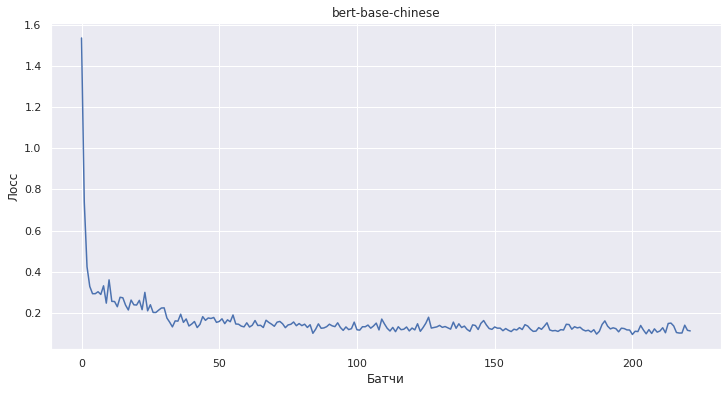

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.33      0.02      0.03       756
   SPAN_2       0.80      0.87      0.83       387

micro avg       0.76      0.31      0.44      1143
macro avg       0.49      0.31      0.30      1143





Опыт №2. Тест модели clue/albert_chinese_small
----------------------------------------------




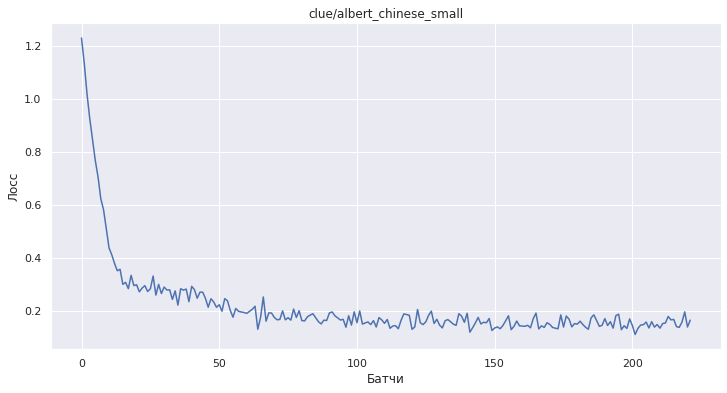

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.00      0.00      0.00       756
   SPAN_2       0.72      0.73      0.73       387

micro avg       0.72      0.25      0.37      1143
macro avg       0.24      0.25      0.25      1143





Опыт №3. Тест модели clue/albert_chinese_tiny
---------------------------------------------




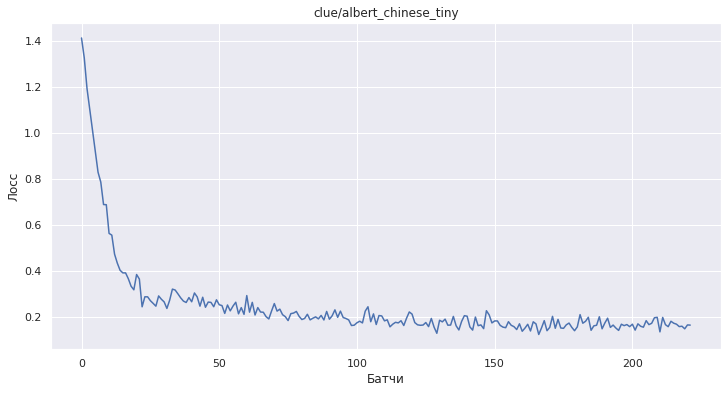

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.33      0.00      0.01       756
   SPAN_2       0.66      0.65      0.66       387

micro avg       0.66      0.22      0.33      1143
macro avg       0.45      0.22      0.23      1143





Опыт №4. Тест модели clue/roberta_chinese_3L312_clue_tiny
---------------------------------------------------------




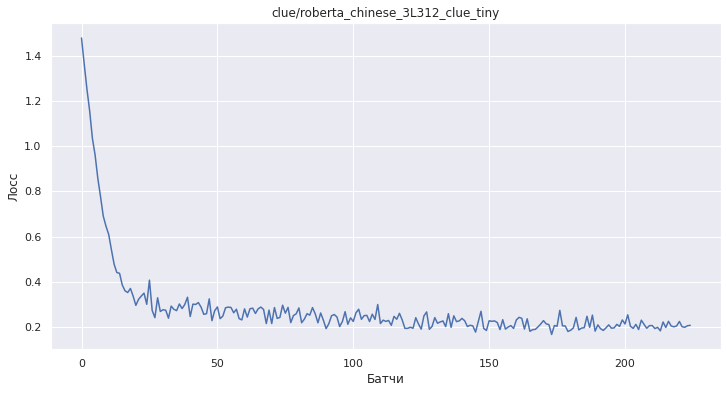

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.00      0.00      0.00       756
   SPAN_2       0.53      0.32      0.40       387

micro avg       0.53      0.11      0.18      1143
macro avg       0.18      0.11      0.14      1143





Опыт №5. Тест модели clue/roberta_chinese_base
----------------------------------------------




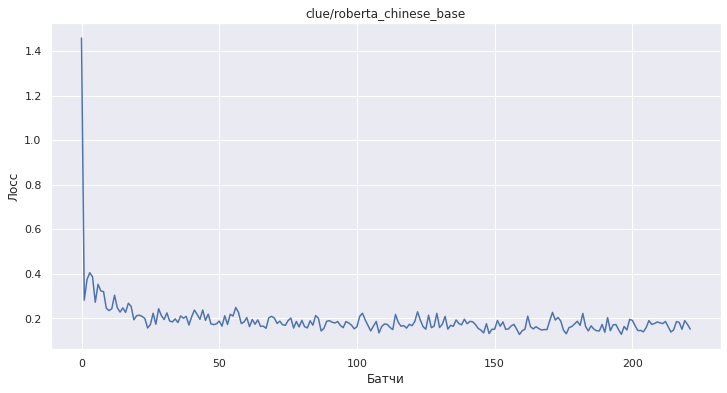

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.38      0.00      0.01       756
   SPAN_2       0.74      0.82      0.78       387

micro avg       0.73      0.28      0.40      1143
macro avg       0.50      0.28      0.27      1143





Опыт №6. Тест модели clue/roberta_chinese_large
-----------------------------------------------




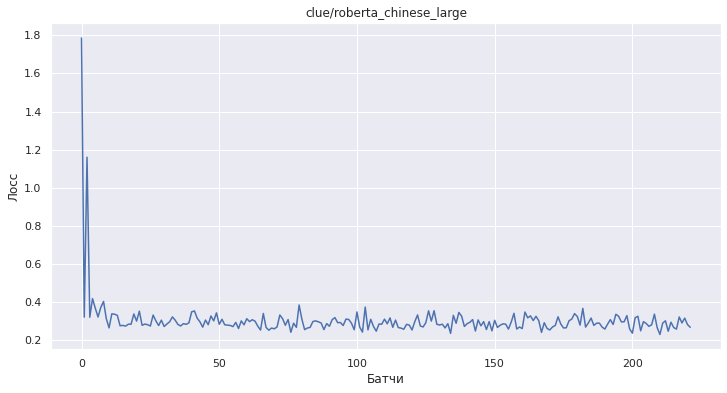

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.00      0.00      0.00       756
   SPAN_2       0.00      0.00      0.00       387

micro avg       0.00      0.00      0.00      1143
macro avg       0.00      0.00      0.00      1143





Опыт №7. Тест модели voidful/albert_chinese_base
------------------------------------------------




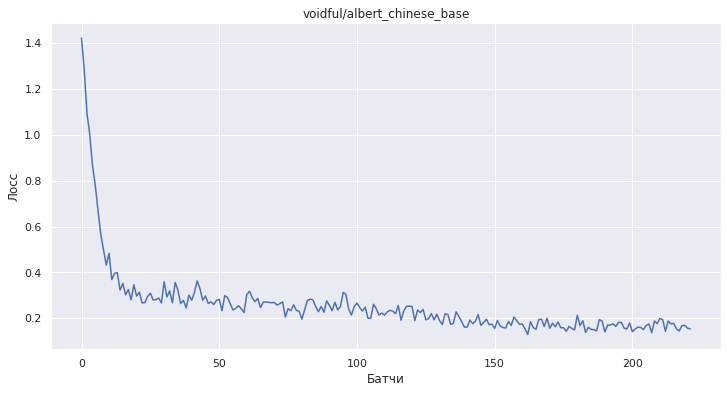

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.00      0.00      0.00       756
   SPAN_2       0.64      0.47      0.54       387

micro avg       0.64      0.16      0.26      1143
macro avg       0.22      0.16      0.18      1143





Опыт №8. Тест модели voidful/albert_chinese_large
-------------------------------------------------




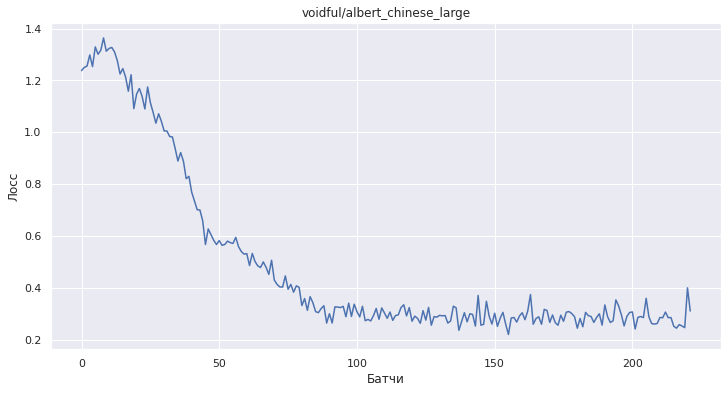

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.00      0.00      0.00       756
   SPAN_2       0.00      0.00      0.00       387

micro avg       0.00      0.00      0.00      1143
macro avg       0.00      0.00      0.00      1143





Опыт №9. Тест модели voidful/albert_chinese_small
-------------------------------------------------




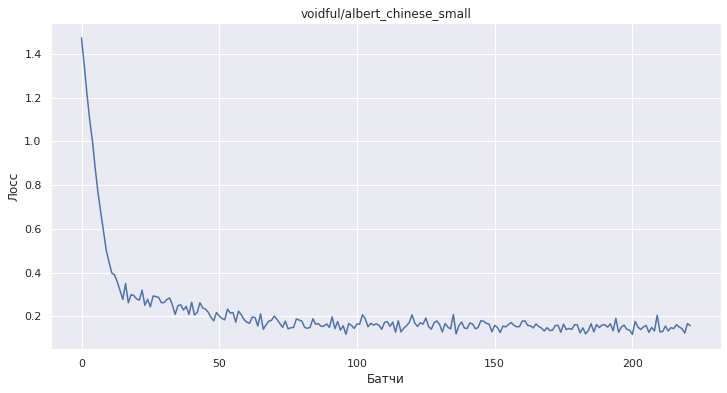

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.50      0.00      0.01       756
   SPAN_2       0.73      0.76      0.75       387

micro avg       0.73      0.26      0.38      1143
macro avg       0.58      0.26      0.26      1143





Опыт №10. Тест модели voidful/albert_chinese_tiny
-------------------------------------------------




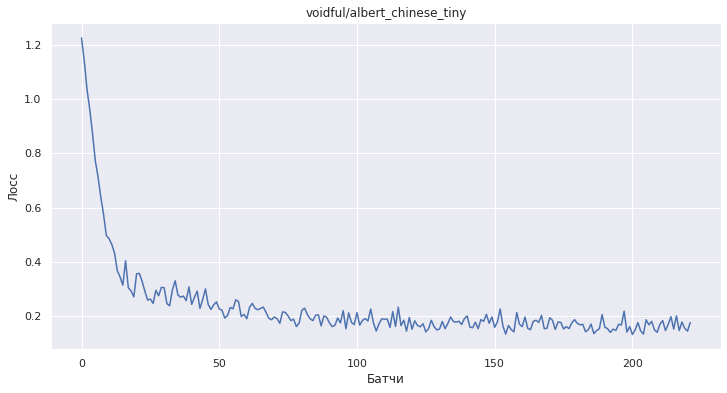

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.33      0.00      0.01       756
   SPAN_2       0.66      0.70      0.68       387

micro avg       0.66      0.24      0.35      1143
macro avg       0.44      0.24      0.23      1143





Опыт №11. Тест модели voidful/albert_chinese_xlarge
---------------------------------------------------




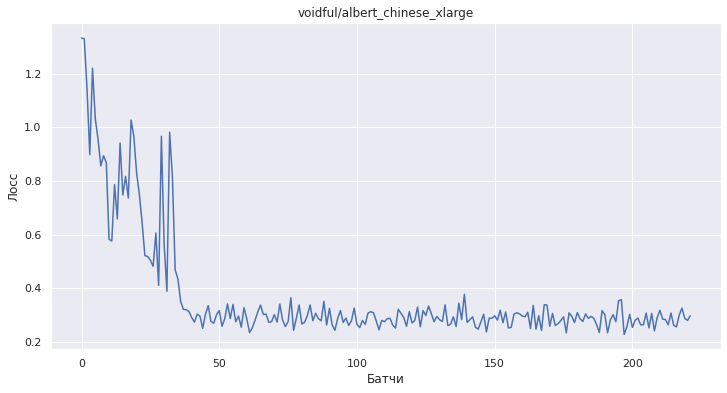

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.00      0.00      0.00       756
   SPAN_2       0.00      0.00      0.00       387

micro avg       0.00      0.00      0.00      1143
macro avg       0.00      0.00      0.00      1143





Опыт №12. Тест модели voidful/albert_chinese_xxlarge
----------------------------------------------------




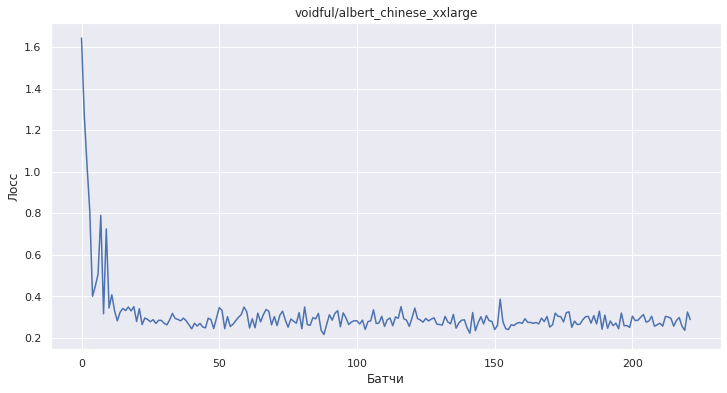

Метрики валидации:
           precision    recall  f1-score   support

   SPAN_1       0.00      0.00      0.00       756
   SPAN_2       0.00      0.00      0.00       387

micro avg       0.00      0.00      0.00      1143
macro avg       0.00      0.00      0.00      1143







In [0]:
for i, model_name in enumerate(models_zoo):
    title = f'Опыт №{i+1}. Тест модели {model_name}'
    print(title)
    print('-'*len(title))
    print(); print();
    if 'xlnet' in model_name:
        tokenizer = XLNetTokenizer.from_pretrained(model_name)
    else:
        tokenizer = BertTokenizer.from_pretrained(model_name)

    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=len(tag2idx),
        output_attentions = False,
        output_hidden_states = False)
    model = AutoModelForTokenClassification.from_pretrained(model_name, config=config)

    # Prepare dataset
    sentences_train, labels_train = json2io(train, tokenizer)
    sentences_dev, labels_dev = json2io(dev, tokenizer)

    assert len(sentences_train) == len(labels_train)
    assert len(sentences_dev) == len(labels_dev)

    tr_inputs, tr_tags, tr_masks = create_indexes(sentences_train, labels_train, tokenizer)
    val_inputs, val_tags, val_masks = create_indexes(sentences_dev, labels_dev, tokenizer)

    train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

    valid_data = TensorDataset(val_inputs, val_masks, val_tags)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

    # Hyperparams
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.0}
    ]
    # Optimazer
    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=LEARNING_RATE
    )
    # Scheduler
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Train model
    loss, model = train_model(
        model=model,
        device=device,
        epochs=EPOCHS,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        max_grad_norm=MAX_GRAD_NORM)
    
    # plot training dynamics
    plot_loss(loss_values=loss, name=model_name)

    # Validate finetuned model
    predictions, true_labels = validate_model(
        model=model,
        device=device,
        valid_dataloader=valid_dataloader)
    
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != 'PAD']
    valid_tags = [tag_values[l_i] for l in true_labels
                                    for l_i in l if tag_values[l_i] != 'PAD']
    
    print('Метрики валидации:')
    print(classification_report(valid_tags, pred_tags))
    print(); print();
    print(); print();